# 🎯 Baseline Model Training

**Goal**: Train a simple CNN to establish baseline performance

**What this notebook does**:
1. Set up data loaders with augmentation
2. Build a simple CNN model
3. Train the model
4. Evaluate on validation set
5. Analyze results

**Target**: 60-70% accuracy

**Author**: Your Name  
**Date**: YYYY-MM-DD

## Setup

In [8]:
import os
import yaml
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("✅ Setup complete")

Using device: cuda
✅ Setup complete


## 1. Load Configuration

In [31]:
# Load config
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

with open('../configs/model_configs/baseline_cnn.yaml', 'r') as f:
    model_config = yaml.safe_load(f)

# Key hyperparameters
BATCH_SIZE = model_config['training']['batch_size']  # 64
EPOCHS = model_config['training']['epochs']          # 50
LEARNING_RATE = model_config['training']['learning_rate']  # 0.001
NUM_CLASSES = config['data']['num_classes']          # 7

#Paths
RAW_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')

print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of classes: {NUM_CLASSES}")

Batch size: 64
Epochs: 50
Learning rate: 0.001
Number of classes: 7


## 2. Data Transforms & Loaders

In [32]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='../data/processed/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='../data/processed/val',
    transform=val_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 39823
Val samples: 4978
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 3. Build Model

**TODO**: Implement CNN architecture based on baseline_cnn.yaml

**Hints**:
- 4 conv blocks: 32 → 64 → 128 → 256 filters
- Each block: Conv → BatchNorm → ReLU → MaxPool → Dropout
- 2 FC layers: 512 → 256 → NUM_CLASSES
- Use nn.Sequential for cleaner code

In [33]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BaselineCNN, self).__init__()
        
        # Feature extraction layers (keep your existing conv layers)
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Add adaptive pooling to get consistent output size
            nn.AdaptiveAvgPool2d((7, 7))  # Forces output to 7x7 spatial dims
        )
        
        # Classifier (now we know the size: 128 channels * 7 * 7 = 6272)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),  # 6272 -> 512
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    

# Create model
model = BaselineCNN(num_classes=NUM_CLASSES).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(7, 7))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_featur

## 4. Training Setup

In [34]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
# TODO: Implement from config (ReduceLROnPlateau)
scheduler_config = config['training']['scheduler']  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',                                    # 'min' for loss
    patience=scheduler_config['patience'],         # epochs to wait
    factor=scheduler_config['factor'],             # multiply LR by this
    min_lr=scheduler_config['min_lr']              # minimum learning rate
)
print("✅ Training setup complete")

✅ Training setup complete


## 5. Training Loop

**TODO**: Implement training and validation functions

In [35]:
# TODO: Implement basic PyTorch data loading test
try:
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    
    # Basic transforms (match your config)
    transform = transforms.Compose([
        transforms.Resize((config['data']['image_size'][0], config['data']['image_size'][0])),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config['data']['normalize_mean'],
            std=config['data']['normalize_std']
        )
    ])
    
    # Load train set using Path objects (like you did earlier in the notebook)
    train_dataset = datasets.ImageFolder(
        root=str(PROCESSED_DIR / 'train'),  # Use PROCESSED_DIR variable
        transform=transform
    )
    
    # Create DataLoader
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['training']['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    # Test loading one batch
    images, labels = next(iter(train_loader))
    
    print(f"✅ Data loading test passed")
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Class mapping: {train_dataset.class_to_idx}")
    print(f"Total training samples: {len(train_dataset)}")
    
except Exception as e:
    print(f"❌ Data loading test failed: {e}")
    import traceback
    traceback.print_exc()

✅ Data loading test passed
Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Number of classes: 7
Class mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Total training samples: 39823


## 6. Train Model

In [36]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0
PATIENCE = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '../models/checkpoints/baseline_best.pth')
        print(f"✅ Saved best model (val_acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n✅ Training complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.23it/s]


Train Loss: 1.6987 | Train Acc: 31.84%
Val Loss:   1.4902 | Val Acc:   40.22%
✅ Saved best model (val_acc: 40.22%)

Epoch 2/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.78it/s]


Train Loss: 1.5121 | Train Acc: 40.21%
Val Loss:   1.3885 | Val Acc:   47.03%
✅ Saved best model (val_acc: 47.03%)

Epoch 3/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.89it/s]


Train Loss: 1.4234 | Train Acc: 44.64%
Val Loss:   1.2958 | Val Acc:   49.98%
✅ Saved best model (val_acc: 49.98%)

Epoch 4/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 19.30it/s]


Train Loss: 1.3492 | Train Acc: 47.88%
Val Loss:   1.2214 | Val Acc:   51.85%
✅ Saved best model (val_acc: 51.85%)

Epoch 5/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.15it/s]


Train Loss: 1.3016 | Train Acc: 49.60%
Val Loss:   1.1943 | Val Acc:   54.22%
✅ Saved best model (val_acc: 54.22%)

Epoch 6/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.68it/s]


Train Loss: 1.2605 | Train Acc: 51.14%
Val Loss:   1.1545 | Val Acc:   55.89%
✅ Saved best model (val_acc: 55.89%)

Epoch 7/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 18.41it/s]


Train Loss: 1.2291 | Train Acc: 52.16%
Val Loss:   1.1133 | Val Acc:   56.41%
✅ Saved best model (val_acc: 56.41%)

Epoch 8/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 17.47it/s]


Train Loss: 1.2034 | Train Acc: 53.15%
Val Loss:   1.0943 | Val Acc:   57.53%
✅ Saved best model (val_acc: 57.53%)

Epoch 9/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 17.42it/s]


Train Loss: 1.1736 | Train Acc: 54.62%
Val Loss:   1.0848 | Val Acc:   58.36%
✅ Saved best model (val_acc: 58.36%)

Epoch 10/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.01it/s]


Train Loss: 1.1507 | Train Acc: 55.48%
Val Loss:   1.0558 | Val Acc:   58.80%
✅ Saved best model (val_acc: 58.80%)

Epoch 11/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.60it/s]


Train Loss: 1.1313 | Train Acc: 56.01%
Val Loss:   1.0376 | Val Acc:   59.70%
✅ Saved best model (val_acc: 59.70%)

Epoch 12/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 18.39it/s]


Train Loss: 1.1075 | Train Acc: 56.96%
Val Loss:   1.0421 | Val Acc:   60.04%
✅ Saved best model (val_acc: 60.04%)

Epoch 13/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 15.45it/s]


Train Loss: 1.0908 | Train Acc: 57.71%
Val Loss:   1.0633 | Val Acc:   58.68%

Epoch 14/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.30it/s]


Train Loss: 1.0698 | Train Acc: 58.52%
Val Loss:   0.9979 | Val Acc:   61.49%
✅ Saved best model (val_acc: 61.49%)

Epoch 15/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.33it/s]


Train Loss: 1.0529 | Train Acc: 59.12%
Val Loss:   0.9931 | Val Acc:   61.85%
✅ Saved best model (val_acc: 61.85%)

Epoch 16/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.18it/s]


Train Loss: 1.0331 | Train Acc: 59.89%
Val Loss:   0.9997 | Val Acc:   61.65%

Epoch 17/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.68it/s]


Train Loss: 1.0144 | Train Acc: 60.66%
Val Loss:   0.9975 | Val Acc:   61.59%

Epoch 18/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 18.21it/s]


Train Loss: 1.0013 | Train Acc: 61.03%
Val Loss:   0.9800 | Val Acc:   62.52%
✅ Saved best model (val_acc: 62.52%)

Epoch 19/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 19.32it/s]


Train Loss: 0.9882 | Train Acc: 61.39%
Val Loss:   0.9812 | Val Acc:   62.33%

Epoch 20/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.59it/s]


Train Loss: 0.9673 | Train Acc: 62.09%
Val Loss:   0.9615 | Val Acc:   63.66%
✅ Saved best model (val_acc: 63.66%)

Epoch 21/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 19.36it/s]


Train Loss: 0.9531 | Train Acc: 62.68%
Val Loss:   0.9809 | Val Acc:   63.22%

Epoch 22/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.75it/s]


Train Loss: 0.9368 | Train Acc: 63.11%
Val Loss:   0.9760 | Val Acc:   62.52%

Epoch 23/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.58it/s]


Train Loss: 0.9173 | Train Acc: 63.92%
Val Loss:   0.9604 | Val Acc:   63.76%
✅ Saved best model (val_acc: 63.76%)

Epoch 24/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.97it/s]


Train Loss: 0.9058 | Train Acc: 64.31%
Val Loss:   0.9471 | Val Acc:   64.64%
✅ Saved best model (val_acc: 64.64%)

Epoch 25/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.81it/s]


Train Loss: 0.8954 | Train Acc: 64.91%
Val Loss:   0.9851 | Val Acc:   62.68%

Epoch 26/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.40it/s]


Train Loss: 0.8806 | Train Acc: 65.51%
Val Loss:   0.9634 | Val Acc:   64.28%

Epoch 27/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.95it/s]


Train Loss: 0.8666 | Train Acc: 65.47%
Val Loss:   0.9618 | Val Acc:   65.03%
✅ Saved best model (val_acc: 65.03%)

Epoch 28/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 17.68it/s]


Train Loss: 0.8509 | Train Acc: 66.29%
Val Loss:   0.9605 | Val Acc:   64.30%

Epoch 29/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.78it/s]


Train Loss: 0.8367 | Train Acc: 66.68%
Val Loss:   0.9763 | Val Acc:   64.64%

Epoch 30/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 23.70it/s]


Train Loss: 0.8264 | Train Acc: 66.93%
Val Loss:   0.9747 | Val Acc:   64.66%

Epoch 31/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.35it/s]


Train Loss: 0.7727 | Train Acc: 69.22%
Val Loss:   0.9738 | Val Acc:   65.31%
✅ Saved best model (val_acc: 65.31%)

Epoch 32/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.32it/s]


Train Loss: 0.7532 | Train Acc: 70.20%
Val Loss:   0.9649 | Val Acc:   65.41%
✅ Saved best model (val_acc: 65.41%)

Epoch 33/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.70it/s]


Train Loss: 0.7365 | Train Acc: 70.52%
Val Loss:   0.9884 | Val Acc:   65.45%
✅ Saved best model (val_acc: 65.45%)

Epoch 34/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.72it/s]


Train Loss: 0.7245 | Train Acc: 70.95%
Val Loss:   0.9891 | Val Acc:   65.25%

Epoch 35/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 23.00it/s]


Train Loss: 0.7172 | Train Acc: 70.95%
Val Loss:   1.0095 | Val Acc:   65.73%
✅ Saved best model (val_acc: 65.73%)

Epoch 36/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 24.07it/s]


Train Loss: 0.7101 | Train Acc: 71.29%
Val Loss:   1.0056 | Val Acc:   65.51%

Epoch 37/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.54it/s]


Train Loss: 0.6744 | Train Acc: 72.64%
Val Loss:   1.0149 | Val Acc:   66.45%
✅ Saved best model (val_acc: 66.45%)

Epoch 38/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 21.69it/s]


Train Loss: 0.6639 | Train Acc: 72.95%
Val Loss:   1.0401 | Val Acc:   65.69%

Epoch 39/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.64it/s]


Train Loss: 0.6524 | Train Acc: 73.21%
Val Loss:   1.0498 | Val Acc:   65.51%

Epoch 40/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.71it/s]


Train Loss: 0.6441 | Train Acc: 73.73%
Val Loss:   1.0419 | Val Acc:   65.77%

Epoch 41/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 23.62it/s]


Train Loss: 0.6385 | Train Acc: 73.84%
Val Loss:   1.0306 | Val Acc:   65.71%

Epoch 42/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.28it/s]


Train Loss: 0.6368 | Train Acc: 73.99%
Val Loss:   1.0516 | Val Acc:   65.89%

Epoch 43/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 22.59it/s]


Train Loss: 0.6143 | Train Acc: 74.89%
Val Loss:   1.0452 | Val Acc:   65.81%

Epoch 44/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 24.87it/s]


Train Loss: 0.6136 | Train Acc: 74.87%
Val Loss:   1.0752 | Val Acc:   65.83%

Epoch 45/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 23.45it/s]


Train Loss: 0.6087 | Train Acc: 74.87%
Val Loss:   1.0889 | Val Acc:   66.17%

Epoch 46/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 23.24it/s]


Train Loss: 0.6067 | Train Acc: 74.90%
Val Loss:   1.0937 | Val Acc:   66.23%

Epoch 47/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 24.45it/s]

Train Loss: 0.6026 | Train Acc: 75.29%
Val Loss:   1.0781 | Val Acc:   65.77%

Early stopping triggered after 47 epochs

✅ Training complete!
Best validation accuracy: 66.45%


## 7. Plot Training History

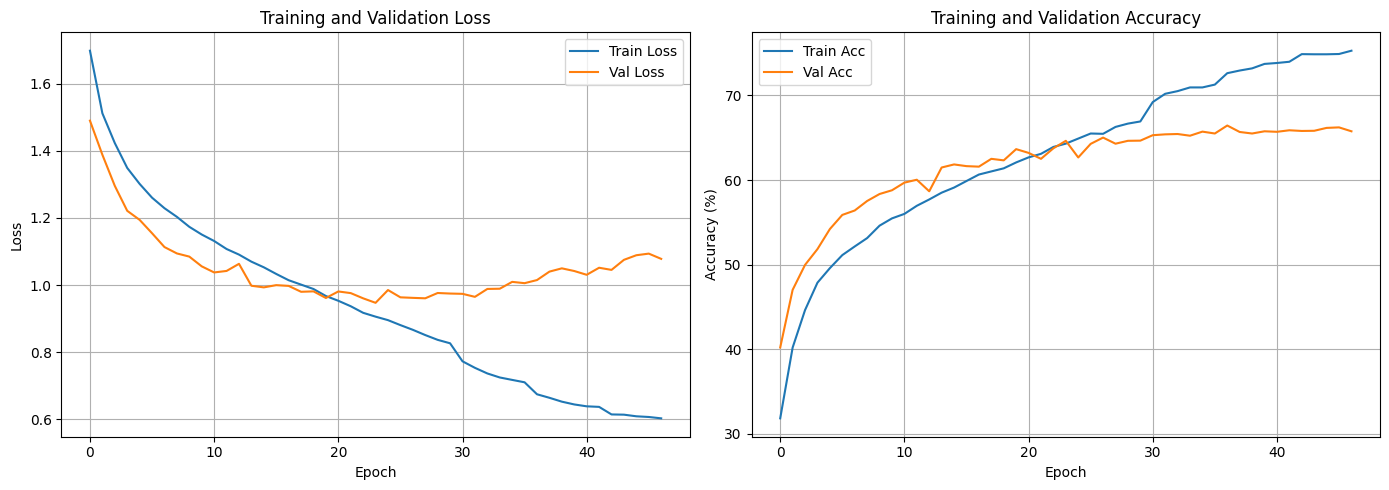

✅ Saved training curves


In [37]:
# TODO: Create training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../results/plots/baseline_training_curves.png', dpi=300)
plt.show()

print("✅ Saved training curves")

## 8. Evaluate on Test Set

**TODO**: Load best model and evaluate

In [38]:
# Load test data
test_dataset = datasets.ImageFolder(
    root='../data/processed/test',
    transform=val_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load best model
model.load_state_dict(torch.load('../models/checkpoints/baseline_best.pth'))

# Evaluate
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:11<00:00,  6.88it/s]


Test Loss: 1.0168
Test Accuracy: 65.81%


## 9. Confusion Matrix

**TODO**: Generate and plot confusion matrix

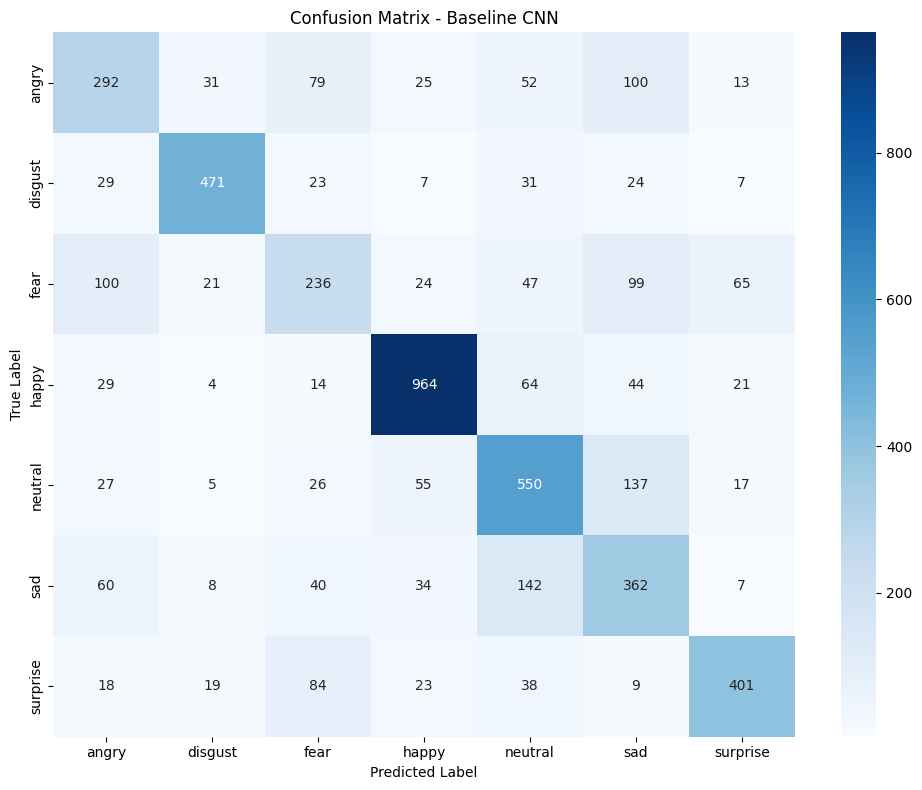


Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.49      0.51       592
     disgust       0.84      0.80      0.82       592
        fear       0.47      0.40      0.43       592
       happy       0.85      0.85      0.85      1140
     neutral       0.60      0.67      0.63       817
         sad       0.47      0.55      0.51       653
    surprise       0.76      0.68      0.71       592

    accuracy                           0.66      4978
   macro avg       0.64      0.63      0.64      4978
weighted avg       0.66      0.66      0.66      4978



In [39]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Baseline CNN')
plt.tight_layout()
plt.savefig('../results/confusion_matrices/baseline_confusion_matrix.png', dpi=300)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=test_dataset.classes))

## Summary

✅ **Results**:
- Train Accuracy: X%
- Val Accuracy: X%
- Test Accuracy: X%

📊 **Observations**:
- TODO: Note overfitting/underfitting
- TODO: Which classes perform worst?
- TODO: What to try next?

🎯 **Next Steps**:
1. Try transfer learning (ResNet/EfficientNet)
2. Tune hyperparameters
3. Add more augmentation
4. Handle class imbalance (if needed)
5. Ensemble methods